In [1]:
import numpy as np
import pandas as pd
import numpy.matlib
import scipy as sc
import random
import datetime
from keras.datasets import fashion_mnist

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

import seaborn as sns
sns.set_palette('Set2', n_colors=5)
sns.set_style('darkgrid')
sns.set_context(font_scale=1.3)
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
def sampling_noniid(X_train, label_train,  num_users, ndat, nlabel):
    '''Sample non-I.I.D user data from MNIST dataset
    Parameters
    ----------
    nlabel: int(1~9)
        number of different types of labels which each user has

    Return
    -------
    list of ndat samples index of each user
    '''
    num_shards, num_imgs = nlabel*num_users, int(ndat//nlabel)
    idx_shard = [i for i in range(num_shards)]
    
    ntrain = num_users * ndat

    # sort labels
    idx_label_pair = [(i, label) for i, label in enumerate(label_train[:ntrain])]
    idx_label_pair = sorted(idx_label_pair, key=lambda x:x[1])
    idx_sorted = [pair[0] for pair in idx_label_pair]

    # divide and assign nlabel number of label per user
    # dict_users = {i: np.array([], dtype=int) for i in range(num_users)}
    list_users = []
    for i in range(num_users):
        user_idx = []
        rand_set = set(np.random.choice(idx_shard, nlabel, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        for rand in rand_set:
            user_idx = np.hstack((user_idx, idx_sorted[rand*num_imgs:(rand+1)*num_imgs]))
            user_idx = user_idx.astype(int).tolist() # convert dtype from float to int
        list_users.append(user_idx)

    return list_users

In [3]:
def sampling_noniid_anna(X_train, label_train, num_users, ndat):
    # line up labels by portions of 50
    ind1= []
    for i in range(10):
        counter = 0
        for j, label in enumerate(label_train):
            if label == i:
                ind1.append(j)
                counter += 1
            if counter >= 50:
                break
    
    user_list = []
    for i in range(num_users):
        start = i * ndat
        end = start + ndat
        user_list.append(ind1[start:end])
    
    return user_list

def sampling_iid(X_train, num_users, ndat):
    ntrain = ndat * num_users
    ind1 = np.random.choice(len(X_train), ntrain, replace=False)
    
    user_list = []
    for i in range(num_users):
        start = i*ndat
        end = start + ndat
        user_list.append(ind1[start:end])
    
    return user_list

In [4]:
# Simple KNN Classifier
def set_data(ndat, nparts, ntest, non_iid='True'):
    
    (Xtrain, ytrain), (Xtest, ytest) = fashion_mnist.load_data()
    ind2 = np.random.choice(10000,ntest,replace=False)
    
    ntrain = ndat*nparts
    
    if non_iid == 'False':
        # random choice
        user_list = sampling_iid(Xtrain, nparts, ndat)
    elif non_iid == 'True':
        user_list = sampling_noniid(Xtrain, ytrain, nparts, ndat, nlabel=2)
    elif non_iid == 'Full_non_iid':
        user_list = sampling_noniid_anna(Xtrain, ytrain, nparts, ndat)

#     Xtest = Xtest[:ntest]
#     ytest = ytest[:ntest]
    
    Xtest = Xtest[ind2]
    ytest = ytest[ind2]
    
    
    # reshape
    Xtrain = normalize(Xtrain.reshape(Xtrain.shape[0], -1))
    Xtest = normalize(Xtest.reshape(Xtest.shape[0], -1))
#     Xtrain = Xtrain.reshape(Xtrain.shape[0], -1) / 255
#     Xtest = Xtest.reshape(Xtest.shape[0], -1) / 255
    
    
    return Xtrain, ytrain, Xtest, ytest, user_list


def knn_cls(Xtrain, Xtest, ytrain, ytest): 
    model = KNeighborsClassifier(n_neighbors=6)
    model.fit(Xtrain, ytrain.ravel())
    score = model.score(Xtest, ytest.ravel())
    
    return score

In [5]:

nparts = 5            # number of parties
ndat = 100            # size of data portions
ntest = 1000          # size of test data
ntrain = nparts*ndat  # size of all training data
nanc = 200           # number of anchor data
repeat = 10           # number of repeated experiments
dd=12


In [7]:
from utils import *

acc_cntr = np.zeros([repeat, nparts])
acc_ind = np.zeros([repeat, nparts])
acc_dc = np.zeros([repeat, nparts])


for r in tqdm(range(repeat)):
    random.seed(r)
    for ii in range(nparts):
        
        Xtrain, ytrain, Xtest, ytest, user_list = set_data(ndat, nparts, ntest, non_iid='Full_non_iid')
        assert len(user_list) == nparts
        anc = make_anchors(Xtrain, nanc)

        print(f'User{ii+1}: {Counter(ytrain[user_list[ii]])}')
            

        # Main
        # train classifier on all data
        
        idx_all = np.ravel(user_list[:ii+1]).tolist()
        X_all = Xtrain[idx_all]
        y_all = ytrain[idx_all]

        cntr = knn_cls(X_all, Xtest, y_all, ytest)
        acc_cntr[r, ii] = cntr
        
        if ii == 0:
            # train classifier on data of one user
            ind = cntr
        acc_ind[r, ii] = ind


        # Proposed method
        
        # pseudo-split of data
        Div_data = []
        for i in range(ii+1):
            Div_data.append({'X':Xtrain[user_list[i]], 'anc':anc, 'Xtest':Xtest}) 
        
        X_dc, X_test_dc = data_collaboration(Div_data, dd)
        assert len(X_dc) == len(X_all)
        
        dc = knn_cls(X_dc, X_test_dc, y_all, ytest)
        acc_dc[r, ii] = dc

knn_cntr = np.around(np.mean(acc_cntr, 0), decimals=2)
knn_ind = np.around(np.mean(acc_ind, 0), decimals=2)
knn_dc = np.around(np.mean(acc_dc, 0), decimals=2)

print('Averaged over {} runs'.format(repeat))
print('Centralized average accuracy:', knn_cntr)
print('Individual average accuracy:', knn_ind)
print('Collaboration average accuracy:', knn_dc)

  0%|          | 0/10 [00:00<?, ?it/s]

User1: Counter({0: 50, 1: 50})
User2: Counter({2: 50, 3: 50})
User3: Counter({4: 50, 5: 50})
User4: Counter({6: 50, 7: 50})
User5: Counter({8: 50, 9: 50})


 10%|█         | 1/10 [00:05<00:49,  5.52s/it]

User1: Counter({0: 50, 1: 50})
User2: Counter({2: 50, 3: 50})
User3: Counter({4: 50, 5: 50})
User4: Counter({6: 50, 7: 50})
User5: Counter({8: 50, 9: 50})


 20%|██        | 2/10 [00:10<00:43,  5.46s/it]

User1: Counter({0: 50, 1: 50})
User2: Counter({2: 50, 3: 50})
User3: Counter({4: 50, 5: 50})
User4: Counter({6: 50, 7: 50})
User5: Counter({8: 50, 9: 50})


 30%|███       | 3/10 [00:16<00:38,  5.44s/it]

User1: Counter({0: 50, 1: 50})
User2: Counter({2: 50, 3: 50})
User3: Counter({4: 50, 5: 50})
User4: Counter({6: 50, 7: 50})
User5: Counter({8: 50, 9: 50})


 40%|████      | 4/10 [00:21<00:32,  5.43s/it]

User1: Counter({0: 50, 1: 50})
User2: Counter({2: 50, 3: 50})
User3: Counter({4: 50, 5: 50})
User4: Counter({6: 50, 7: 50})
User5: Counter({8: 50, 9: 50})


 50%|█████     | 5/10 [00:27<00:27,  5.53s/it]

User1: Counter({0: 50, 1: 50})
User2: Counter({2: 50, 3: 50})
User3: Counter({4: 50, 5: 50})
User4: Counter({6: 50, 7: 50})
User5: Counter({8: 50, 9: 50})


 60%|██████    | 6/10 [00:32<00:22,  5.55s/it]

User1: Counter({0: 50, 1: 50})
User2: Counter({2: 50, 3: 50})
User3: Counter({4: 50, 5: 50})
User4: Counter({6: 50, 7: 50})
User5: Counter({8: 50, 9: 50})


 70%|███████   | 7/10 [00:38<00:16,  5.48s/it]

User1: Counter({0: 50, 1: 50})
User2: Counter({2: 50, 3: 50})
User3: Counter({4: 50, 5: 50})
User4: Counter({6: 50, 7: 50})
User5: Counter({8: 50, 9: 50})


 80%|████████  | 8/10 [00:44<00:11,  5.58s/it]

User1: Counter({0: 50, 1: 50})
User2: Counter({2: 50, 3: 50})
User3: Counter({4: 50, 5: 50})
User4: Counter({6: 50, 7: 50})
User5: Counter({8: 50, 9: 50})


 90%|█████████ | 9/10 [00:49<00:05,  5.57s/it]

User1: Counter({0: 50, 1: 50})
User2: Counter({2: 50, 3: 50})
User3: Counter({4: 50, 5: 50})
User4: Counter({6: 50, 7: 50})
User5: Counter({8: 50, 9: 50})


100%|██████████| 10/10 [00:55<00:00,  5.53s/it]

Averaged over 10 runs
Centralized average accuracy: [0.19 0.36 0.49 0.58 0.74]
Individual average accuracy: [0.19 0.19 0.19 0.19 0.19]
Collaboration average accuracy: [0.19 0.24 0.26 0.29 0.28]


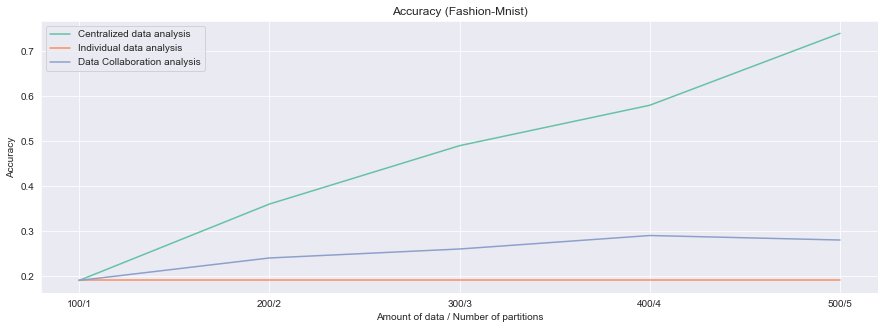

In [8]:
plt.figure(figsize=(15,5))
plt.plot(knn_cntr, label='Centralized data analysis')
plt.plot(knn_ind, label='Individual data analysis')
plt.plot(knn_dc, label='Data Collaboration analysis')
plt.ylabel('Accuracy')
plt.xlabel('Amount of data / Number of partitions')
locs, labels = plt.xticks()
plt.xticks(np.arange(0, 5, step = 1), ('100/1', '200/2', '300/3', '400/4', '500/5'))
plt.title("Accuracy (Fashion-Mnist)")
plt.legend()

In [9]:
centralized_model = create_compiled_keras_model(Xtrain.shape[1])
cntr_history_callback =centralized_model.fit(X_all, y_all, validation_data= (Xtest, ytest), batch_size=32, epochs=12) 

Train on 500 samples, validate on 1000 samples
Epoch 1/12
500/500 [==============================] - 0s 958us/sample - loss: 2.1085 - sparse_categorical_accuracy: 0.3660 - val_loss: 1.7747 - val_sparse_categorical_accuracy: 0.5300
Epoch 2/12
500/500 [==============================] - 0s 205us/sample - loss: 1.5339 - sparse_categorical_accuracy: 0.5100 - val_loss: 1.2237 - val_sparse_categorical_accuracy: 0.6520
Epoch 3/12
500/500 [==============================] - 0s 211us/sample - loss: 1.0921 - sparse_categorical_accuracy: 0.6280 - val_loss: 0.9796 - val_sparse_categorical_accuracy: 0.6960
Epoch 4/12
500/500 [==============================] - 0s 203us/sample - loss: 0.9065 - sparse_categorical_accuracy: 0.6640 - val_loss: 0.8739 - val_sparse_categorical_accuracy: 0.6900
Epoch 5/12
500/500 [==============================] - 0s 207us/sample - loss: 0.7779 - sparse_categorical_accuracy: 0.7260 - val_loss: 0.8077 - val_sparse_categorical_accuracy: 0.6930
Epoch 6/12
500/500 [=============

In [10]:
X_ind, y_ind = Div_data[0]['X'], ytrain[user_list[0]]
individual_model = create_compiled_keras_model(X_ind.shape[1])
ind_history_callback = individual_model.fit(X_ind, y_ind, validation_data=(Xtest, ytest),
                                            batch_size=32, epochs=12)

Train on 100 samples, validate on 1000 samples
Epoch 1/12
100/100 [==============================] - 0s 3ms/sample - loss: 2.1758 - sparse_categorical_accuracy: 0.5500 - val_loss: 2.2803 - val_sparse_categorical_accuracy: 0.2030
Epoch 2/12
100/100 [==============================] - 0s 531us/sample - loss: 1.6305 - sparse_categorical_accuracy: 0.8700 - val_loss: 2.3610 - val_sparse_categorical_accuracy: 0.2010
Epoch 3/12
100/100 [==============================] - 0s 555us/sample - loss: 0.9927 - sparse_categorical_accuracy: 0.8800 - val_loss: 2.7931 - val_sparse_categorical_accuracy: 0.2110
Epoch 4/12
100/100 [==============================] - 0s 544us/sample - loss: 0.4887 - sparse_categorical_accuracy: 0.9200 - val_loss: 3.7302 - val_sparse_categorical_accuracy: 0.2120
Epoch 5/12
100/100 [==============================] - 0s 544us/sample - loss: 0.2939 - sparse_categorical_accuracy: 0.9100 - val_loss: 4.8170 - val_sparse_categorical_accuracy: 0.2120
Epoch 6/12
100/100 [===============

In [11]:
X_dc, X_test_dc = data_collaboration(Div_data, dd)
dc_model = create_compiled_keras_model(X_dc.shape[1])
dc_history_callback = dc_model.fit(X_dc, y_all, validation_data=(X_test_dc, ytest),
                                   batch_size=32, epochs=12)

Train on 500 samples, validate on 1000 samples
Epoch 1/12
500/500 [==============================] - 0s 772us/sample - loss: 2.2779 - sparse_categorical_accuracy: 0.3540 - val_loss: 2.2703 - val_sparse_categorical_accuracy: 0.3670
Epoch 2/12
500/500 [==============================] - 0s 116us/sample - loss: 2.1843 - sparse_categorical_accuracy: 0.5380 - val_loss: 2.2107 - val_sparse_categorical_accuracy: 0.3530
Epoch 3/12
500/500 [==============================] - 0s 135us/sample - loss: 2.0058 - sparse_categorical_accuracy: 0.6480 - val_loss: 2.1373 - val_sparse_categorical_accuracy: 0.3710
Epoch 4/12
500/500 [==============================] - 0s 121us/sample - loss: 1.7492 - sparse_categorical_accuracy: 0.6160 - val_loss: 2.0830 - val_sparse_categorical_accuracy: 0.3510
Epoch 5/12
500/500 [==============================] - 0s 125us/sample - loss: 1.4768 - sparse_categorical_accuracy: 0.6500 - val_loss: 2.0649 - val_sparse_categorical_accuracy: 0.4070
Epoch 6/12
500/500 [=============

In [12]:
initial_model = create_compiled_keras_model(Div_data[0]['X'].shape[1])
repeat = 5

FedTrain = np.zeros((repeat, 12))
FedTest = np.zeros((repeat, 12))
FedAcc = np.zeros((repeat, 12))

for i in range(repeat):
    

    for r in range(12):

        deltas = []

        for c in range(nparts):

            federated_model = create_compiled_keras_model(Div_data[0]['X'].shape[1])

            federated_model.set_weights(initial_model.get_weights())

            history_callback = federated_model.fit(Div_data[c]['X'], ytrain[user_list[c]], 
                                                   batch_size=32, epochs=3, verbose=0)


            delta = np.array(initial_model.get_weights()) - np.array(federated_model.get_weights())

            deltas.append(delta)
        print('Epoch {}/12'.format(r+1))
        delt_av = (deltas[0] + deltas[1] + deltas[2] + deltas[3] + deltas[4]) / 5
        new_weights = np.array(initial_model.get_weights()) - delt_av
        initial_model.set_weights(new_weights)

        FedTrain[i, r] = initial_model.evaluate(Xtrain, ytrain)[0]
        validation = initial_model.evaluate(Xtest, ytest)
        FedTest[i, r] = validation[0]
        FedAcc[i, r] = validation[1]

FedTrain = np.mean(FedTrain, axis=0)
FedTest = np.mean(FedTest, axis=0)
FedAcc = np.mean(FedAcc, axis=0)

Epoch 1/12
1000/1000 [==============================] - 0s 111us/sample - loss: 2.2206 - sparse_categorical_accuracy: 0.1000
Epoch 2/12
1000/1000 [==============================] - 0s 32us/sample - loss: 2.0861 - sparse_categorical_accuracy: 0.4610
Epoch 3/12
1000/1000 [==============================] - 0s 33us/sample - loss: 1.9400 - sparse_categorical_accuracy: 0.4780
Epoch 4/12
1000/1000 [==============================] - 0s 35us/sample - loss: 1.8175 - sparse_categorical_accuracy: 0.4380
Epoch 5/12
1000/1000 [==============================] - 0s 32us/sample - loss: 1.7130 - sparse_categorical_accuracy: 0.4180
Epoch 6/12
1000/1000 [==============================] - 0s 31us/sample - loss: 1.6214 - sparse_categorical_accuracy: 0.5120
Epoch 7/12
1000/1000 [==============================] - 0s 33us/sample - loss: 1.5479 - sparse_categorical_accuracy: 0.4960
Epoch 8/12
1000/1000 [==============================] - 0s 32us/sample - loss: 1.4967 - sparse_categorical_accuracy: 0.4970
Epoch 9

1000/1000 [==============================] - 0s 39us/sample - loss: 1.0433 - sparse_categorical_accuracy: 0.5990
Epoch 11/12
1000/1000 [==============================] - 0s 51us/sample - loss: 1.0292 - sparse_categorical_accuracy: 0.6160
Epoch 12/12
1000/1000 [==============================] - 0s 37us/sample - loss: 1.0123 - sparse_categorical_accuracy: 0.6120
Epoch 1/12
1000/1000 [==============================] - 0s 44us/sample - loss: 0.9977 - sparse_categorical_accuracy: 0.6130
Epoch 2/12
1000/1000 [==============================] - 0s 43us/sample - loss: 1.0192 - sparse_categorical_accuracy: 0.5860
Epoch 3/12
1000/1000 [==============================] - 0s 35us/sample - loss: 0.9810 - sparse_categorical_accuracy: 0.6250
Epoch 4/12
1000/1000 [==============================] - 0s 39us/sample - loss: 1.0166 - sparse_categorical_accuracy: 0.5990
Epoch 5/12
1000/1000 [==============================] - 0s 39us/sample - loss: 0.9994 - sparse_categorical_accuracy: 0.6010
Epoch 6/12
1000/1

In [0]:
# initial_model = create_compiled_keras_model(Div_data_dc[0].shape[1])

# DCFedTrain = []
# DCFedTest = []
# DCFedAcc = []

# for r in range(12):
    
#     deltas = []

#     for c in range(nparts):

#         federated_model = create_compiled_keras_model(Div_data_dc[0].shape[1])

#         federated_model.set_weights(initial_model.get_weights())

#         history_callback = federated_model.fit(Div_data_dc[c], Div_data[c]['y'], 
#                                                batch_size=32, epochs=1, verbose=0)

        
#         delta = np.array(initial_model.get_weights()) - np.array(federated_model.get_weights())

#         deltas.append(delta)
#     print('Epoch {}/12'.format(r+1))
#     delt_av = (deltas[0] + deltas[1] + deltas[2] + deltas[3] + deltas[4]) / 5
#     new_weights = np.array(initial_model.get_weights()) - delt_av
#     initial_model.set_weights(new_weights)
    
#     DCFedTrain.append(initial_model.evaluate(X_dc, ytrain)[0])
#     validation = initial_model.evaluate(X_test_dc, ytest)
#     DCFedTest.append(validation[0])
#     DCFedAcc.append(validation[1])

Epoch 1/12
200/200 [==============================] - 0s 43us/sample - loss: 2.2975 - sparse_categorical_accuracy: 0.1850
Epoch 2/12
200/200 [==============================] - 0s 42us/sample - loss: 2.2935 - sparse_categorical_accuracy: 0.2450
Epoch 3/12
200/200 [==============================] - 0s 59us/sample - loss: 2.2892 - sparse_categorical_accuracy: 0.2350
Epoch 4/12
200/200 [==============================] - 0s 48us/sample - loss: 2.2846 - sparse_categorical_accuracy: 0.2500
Epoch 5/12
200/200 [==============================] - 0s 43us/sample - loss: 2.2800 - sparse_categorical_accuracy: 0.2500
Epoch 6/12
200/200 [==============================] - 0s 42us/sample - loss: 2.2750 - sparse_categorical_accuracy: 0.2500
Epoch 7/12
200/200 [==============================] - 0s 45us/sample - loss: 2.2702 - sparse_categorical_accuracy: 0.2550
Epoch 8/12
200/200 [==============================] - 0s 50us/sample - loss: 2.2647 - sparse_categorical_accuracy: 0.2750
Epoch 9/12
200/200 [====

Text(0.5, 1.0, 'Validation Accuracy, NN')

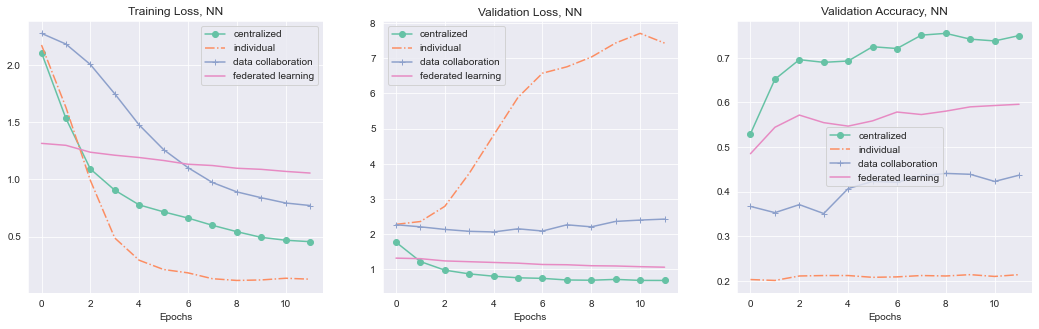

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))


ax[0].plot(cntr_history_callback.history['loss'], '-o', label='centralized')
ax[0].plot(ind_history_callback.history['loss'], '-.', label='individual')
ax[0].plot(dc_history_callback.history['loss'], '-+',label='data collaboration')
ax[0].plot(FedTrain, label='federated learning')
# ax[0].plot(DCFedTrain, label='dc federated learning')
ax[0].set_xlabel('Epochs')
ax[0].legend()
ax[0].set_title('Training Loss, NN')

ax[1].plot(cntr_history_callback.history['val_loss'], '-o',label='centralized')
ax[1].plot(ind_history_callback.history['val_loss'], '-.',label='individual')
ax[1].plot(dc_history_callback.history['val_loss'], '-+', label='data collaboration')
ax[1].plot(FedTest, label='federated learning')
# ax[1].plot(DCFedTest, label='dc federated learning')
ax[1].set_xlabel('Epochs')
ax[1].legend()
ax[1].set_title('Validation Loss, NN')

ax[2].plot(cntr_history_callback.history['val_sparse_categorical_accuracy'], '-o', label='centralized')
ax[2].plot(ind_history_callback.history['val_sparse_categorical_accuracy'], '-.', label='individual')
ax[2].plot(dc_history_callback.history['val_sparse_categorical_accuracy'], '-+', label='data collaboration')
ax[2].plot(FedAcc, label='federated learning')
# ax[2].plot(DCFedAcc, label='dc federated learning')
ax[2].set_xlabel('Epochs')
ax[2].legend()
ax[2].set_title('Validation Accuracy, NN')

ホーン，もしかしたらサンプリングが完全なNon-IIDの時はDCの方が優れているかもしれない？

と思ったけど完全なNon-iidの実験を再現できない問題．うぜぇ．

やっと原因わかりました．AnnaさんがXtestをanchorにしてたからだった．